# Multitasking by concurrent.futures library

1. [concurrent.futures library](https://docs.python.org/3/library/concurrent.futures.html#module-concurrent.futures)

2. [bfortuner's notebook](https://github.com/bfortuner/ml-study/blob/master/multitasking_python.ipynb)

In [10]:
import concurrent.futures
from concurrent.futures import ThreadPoolExecutor, ProcessPoolExecutor
import numpy as np
import urllib.request
import math

## 1. Examples from [concurrent.futures library](https://docs.python.org/3/library/concurrent.futures.html#module-concurrent.futures)

### 17.4.2.1. ThreadPoolExecutor Example

In [9]:
URLS = ['http://www.foxnews.com/',
        'http://www.cnn.com/',
        'http://europe.wsj.com/',
        'http://www.bbc.co.uk/',
        'http://some-made-up-domain.com/']

# Retrieve a single page and report the URL and contents
def load_url(url, timeout):
    with urllib.request.urlopen(url, timeout=timeout) as conn:
        return conn.read()
    
# We can use a with statement to ensure threads are cleaned up promptly
with ThreadPoolExecutor(max_workers = 5) as executor:
    # Start the load operations and mark each future with its URL
    future_to_url = {executor.submit(load_url, url, 60): url for url in URLS}
    for future in concurrent.futures.as_completed(future_to_url):
        url = future_to_url[future]
        try:
            data = future.result()
        except Exception as exc:
            print('%r generated an exception: %s' % (url, exc))
        else:
            print('%r page is %d bytes' % (url, len(data)))

'http://some-made-up-domain.com/' generated an exception: <urlopen error [Errno -2] Name or service not known>
'http://www.cnn.com/' page is 154122 bytes
'http://www.foxnews.com/' page is 224976 bytes
'http://europe.wsj.com/' page is 953856 bytes
'http://www.bbc.co.uk/' page is 282791 bytes


### 17.4.3.1. ProcessPoolExecutor Example

In [11]:
PRIMES = [
    112272535095293,
    112582705942171,
    112272535095293,
    115280095190773,
    115797848077099,
    1099726899285419]

def is_prime(n):
    if n % 2 == 0:
        return False
    
    sqrt_n = int(math.floor(math.sqrt(n)))
    for i in range(3, sqrt_n+1, 2):
        if n % i ==0: return False
    return True

with ProcessPoolExecutor() as executor:
    for number, prime in zip(PRIMES, executor.map(is_prime, PRIMES)):
        print('%d is prime: %s' % (number, prime))

112272535095293 is prime: True
112582705942171 is prime: True
112272535095293 is prime: True
115280095190773 is prime: True
115797848077099 is prime: True
1099726899285419 is prime: False


## 2. [bfortuner's notebook](https://github.com/bfortuner/ml-study/blob/master/multitasking_python.ipynb)

In [12]:
from concurrent.futures import ProcessPoolExecutor, ThreadPoolExecutor
import numpy as np
import time
import matplotlib.pyplot as plt
import glob
from PIL import Image
import random
import string
%matplotlib inline

In [13]:
MULTITHREADING_TITLE="Multithreading"
MULTIPROCESSING_TITLE="Multiprocessing"

def visualize_runtimes(results, title):
    start,stop = np.array(results).T
    plt.barh(range(len(start)), stop-start, left=start)
    plt.grid(axis='x')
    plt.ylabel('Tasks')
    plt.xlabel('Seconds')
    plt.title(title)
    return stop[-1]-start[0]

In [22]:
def multithreading(func, args, workers):
    begin_time = time.time()
    with ThreadPoolExecutor(max_workers=workers) as executor:
        res = executor.map(func, args, [begin_time for i in range(len(args))])
    return list(res)

def multiprocessing(func, args, workers):
    begin_time = time.time()
    with ProcessPoolExecutor(max_workers=workers) as executor:
        res = executor.map(func, args, [begin_time for i in range(len(args))])
    return list(res)
    

# API Calls

In [15]:
from urllib.request import urlopen

def download(url, base):
    start = time.time() - base
    try:
        resp = urlopen(url)
    except Exception as e:
        print('ERROR: %s' % e)
    stop = time.time() - base
    return start,stop

In [18]:
N = 16
#URL = 'http://scholar.princeton.edu/sites/default/files/oversize_pdf_test_0.pdf'
URL = 'http://www.pdf995.com/samples/pdf.pdf'
urls = [URL for i in range(N)]

#### Serial

In [19]:
%timeit -n 1 [download(url, time.time()) for url in urls]

10.4 s ± 564 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


#### Multithreading

11.696552276611328

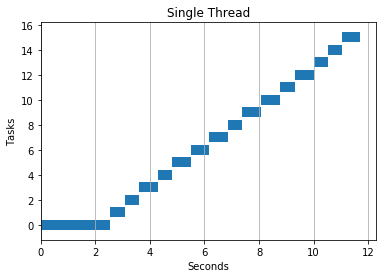

In [23]:
visualize_runtimes(multithreading(download, urls, 1), "Single Thread")

5.002195119857788

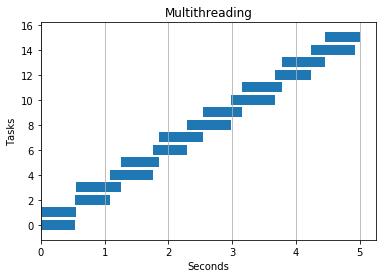

In [35]:
visualize_runtimes(multithreading(download, urls, 2),MULTITHREADING_TITLE)

2.559314250946045

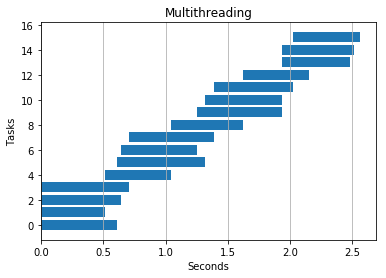

In [34]:
visualize_runtimes(multithreading(download, urls, 4),MULTITHREADING_TITLE)

#### Multiprocessing

10.663392066955566

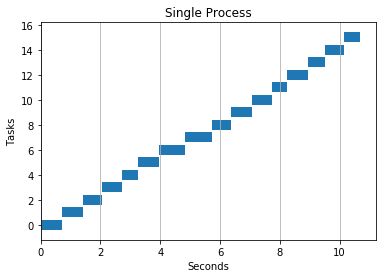

In [30]:
visualize_runtimes(multiprocessing(download, urls, 1), "Single Process")

4.858877897262573

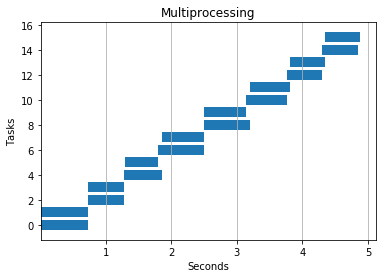

In [31]:
visualize_runtimes(multiprocessing(download, urls, 2), MULTIPROCESSING_TITLE)

3.558328866958618

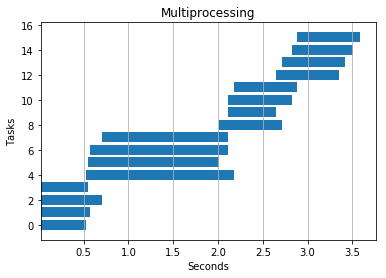

In [32]:
visualize_runtimes(multiprocessing(download, urls, 4), MULTIPROCESSING_TITLE)

# IO Heavy

In [36]:
def io_heavy(text,base):
    start = time.time() - base
    f = open('output.txt', 'wt', encoding='utf-8')
    f.write(text)
    f.close()
    stop = time.time() - base
    return start,stop

In [37]:
N=12
TEXT = ''.join(random.choice(string.ascii_lowercase) for i in range(10**7*5))

#### Serial

In [38]:
%timeit -n 1 [io_heavy(TEXT, time.time()) for i in range(N)]

6.19 s ± 513 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


#### Multithreading

Should see good benefit from this

5.416173458099365

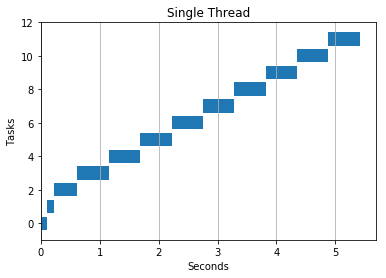

In [39]:
visualize_runtimes(multithreading(io_heavy, [TEXT for i in range(N)], 1),"Single Thread")

2.207620620727539

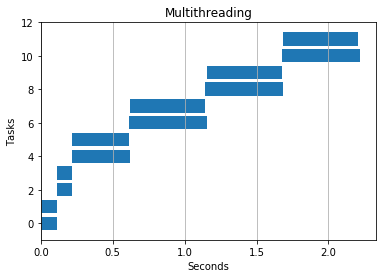

In [40]:
visualize_runtimes(multithreading(io_heavy, [TEXT for i in range(N)], 2),MULTITHREADING_TITLE)

0.9426627159118652

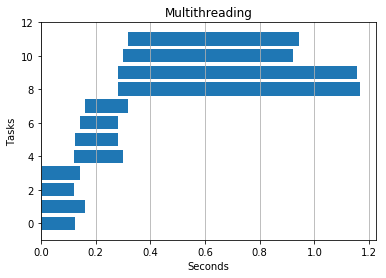

In [41]:
visualize_runtimes(multithreading(io_heavy, [TEXT for i in range(N)], 4),MULTITHREADING_TITLE)

#### Multiprocessing

5.413949489593506

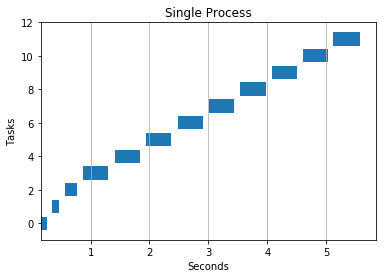

In [42]:
visualize_runtimes(multiprocessing(io_heavy, [TEXT for i in range(N)], 1),"Single Process")

2.048119306564331

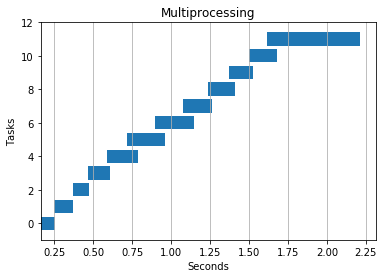

In [43]:
visualize_runtimes(multiprocessing(io_heavy, [TEXT for i in range(N)], 2),MULTIPROCESSING_TITLE)

2.3097496032714844

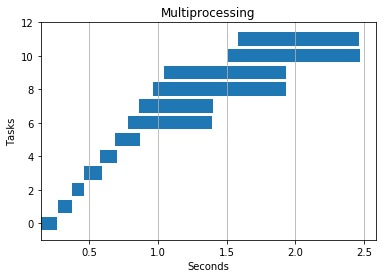

In [45]:
visualize_runtimes(multiprocessing(io_heavy, [TEXT for i in range(N)], 4),MULTIPROCESSING_TITLE)

# Numpy Functions

### Numpy Addition

In [47]:
#Does not use parallel processing by default
#But will see speedups if multiprocessing used
#Because numpy sidesteps python's GIL
def addition(i, base):
    start = time.time() - base
    res = a + b
    stop = time.time() - base
    return start,stop

In [48]:
DIMS = 20000
N = 20
DIMS_ARR = [DIMS for i in range(N)]
a = np.random.rand(DIMS,DIMS)
b = np.random.rand(DIMS,DIMS)

#### Serial

In [50]:
%timeit -n 1 [addition(1, time.time()) for i in range(N)]

28.9 s ± 189 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


#### Multithreading

Some benefit for numpy addition (operation avoids GIL, but not parallel by default)

28.694807767868042

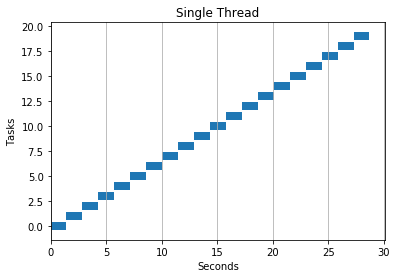

In [51]:
visualize_runtimes(multithreading(addition, [i for i in range(N)], 1),"Single Thread")

14.478878736495972

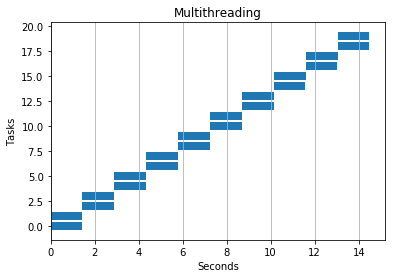

In [52]:
visualize_runtimes(multithreading(addition, [i for i in range(N)], 2),MULTITHREADING_TITLE)

12.254607915878296

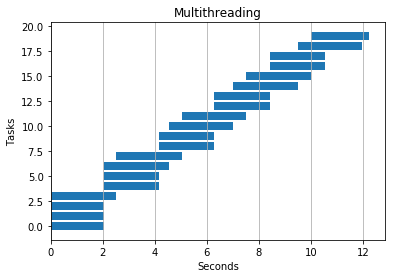

In [53]:
visualize_runtimes(multithreading(addition, [i for i in range(N)], 4),MULTITHREADING_TITLE)

#### Multiprocessing

Some benefit for numpy addition (operation avoids GIL, but not parallel by default)

28.70507788658142

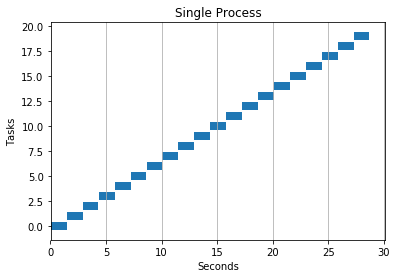

In [54]:
visualize_runtimes(multiprocessing(addition, [i for i in range(N)], 1),"Single Process")

14.77769947052002

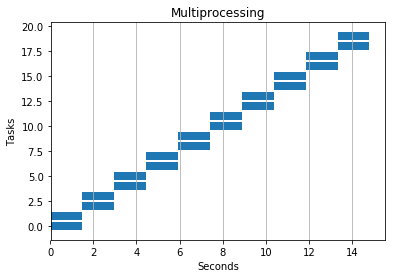

In [55]:
visualize_runtimes(multiprocessing(addition, [i for i in range(N)], 2),MULTIPROCESSING_TITLE)

10.505483865737915

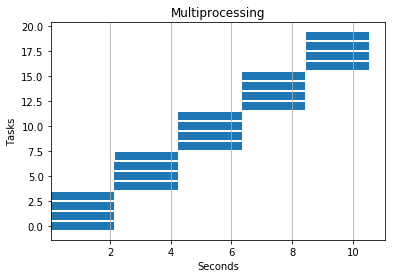

In [56]:
visualize_runtimes(multiprocessing(addition, [i for i in range(N)], 4),MULTIPROCESSING_TITLE)

### Dot Product

In [57]:
#Automatic parallel processing built works out of the box
#Depending on BLAS impl, MKL (default with anaconda3) does
#Should NOT see speedups with multithreading/processing
def dot_product(i, base):
    start = time.time() - base
    res = np.dot(a,b)
    stop = time.time() - base
    return start,stop

DIMS = 3000
N = 10
DIMS_ARR = [DIMS for i in range(N)]
a = np.random.rand(DIMS,DIMS)
b = np.random.rand(DIMS,DIMS)

#### Serial

In [58]:
%timeit -n 1 [dot_product(i, time.time()) for i in range(N)]

9.73 s ± 36.6 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


#### Multithreading

No benefit on dot product (since already parallel)

9.742437601089478

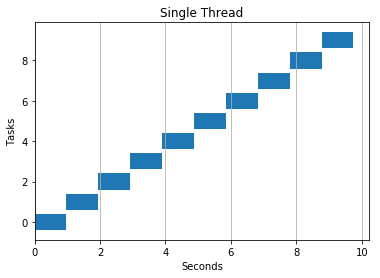

In [59]:
visualize_runtimes(multithreading(dot_product, [i for i in range(N)], 1),"Single Thread")

13.786595821380615

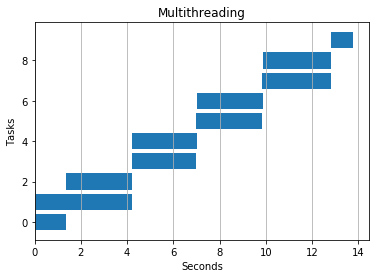

In [61]:
visualize_runtimes(multithreading(dot_product, [i for i in range(N)], 2),MULTITHREADING_TITLE)

15.664173603057861

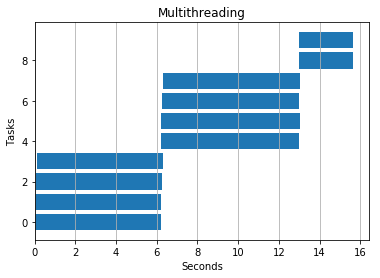

In [62]:
visualize_runtimes(multithreading(dot_product, [i for i in range(N)], 4),MULTITHREADING_TITLE)

#### Multiprocessing

No benefit on dot product (since already parallel)

9.714248180389404

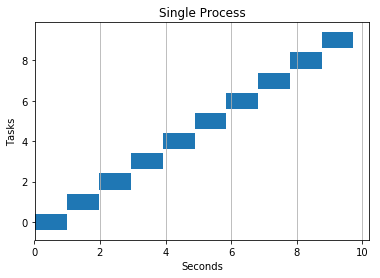

In [63]:
visualize_runtimes(multiprocessing(dot_product, [i for i in range(N)], 1),"Single Process")

10.236183404922485

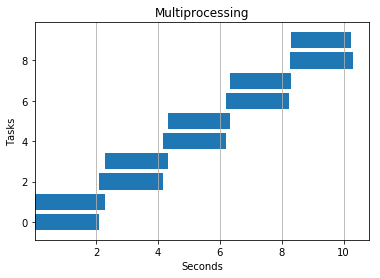

In [64]:
visualize_runtimes(multiprocessing(dot_product, [i for i in range(N)], 2),MULTIPROCESSING_TITLE)

15.892701625823975

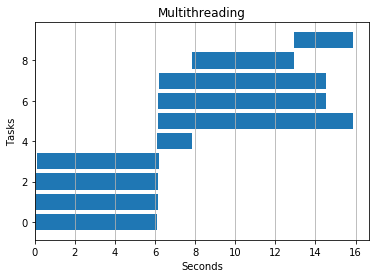

In [65]:
visualize_runtimes(multithreading(dot_product, [i for i in range(N)], 4),MULTITHREADING_TITLE)

### CPU Intensive

In [67]:
def cpu_heavy(n,base):
    start = time.time() - base
    count = 0
    for i in range(n):
        count += i
    stop = time.time() - base
    return start,stop

In [68]:
N = 10**7
ITERS = 10

#### Serial

In [69]:
%timeit -n 1 [cpu_heavy(N, time.time()) for i in range(ITERS)]

5.7 s ± 14.1 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


#### Multithreading

No benefit on CPU-intensive tasks

5.629709482192993

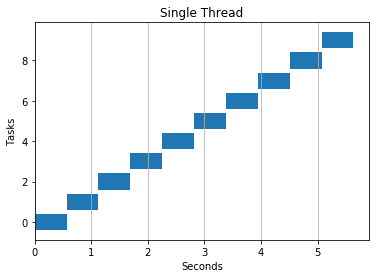

In [70]:
visualize_runtimes(multithreading(cpu_heavy, [N for i in range(ITERS)], 1),"Single Thread")

5.964886903762817

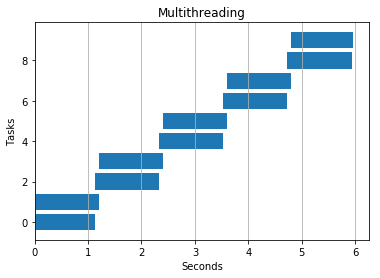

In [71]:
visualize_runtimes(multithreading(cpu_heavy, [N for i in range(ITERS)], 2),MULTITHREADING_TITLE)

5.614948987960815

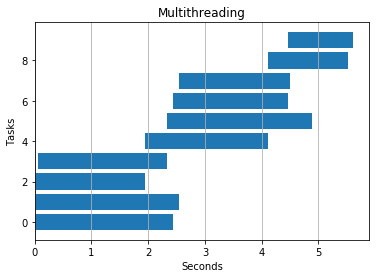

In [72]:
visualize_runtimes(multithreading(cpu_heavy, [N for i in range(ITERS)], 4),MULTITHREADING_TITLE)

#### Multiprocessing

Shows benefits on CPU-intensive tasks

5.986875772476196

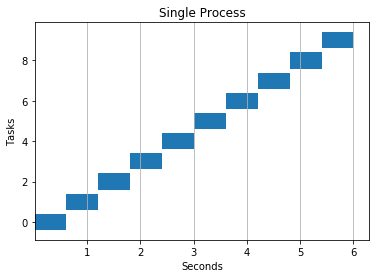

In [73]:
visualize_runtimes(multiprocessing(cpu_heavy, [N for i in range(ITERS)], 1),"Single Process")

2.9089860916137695

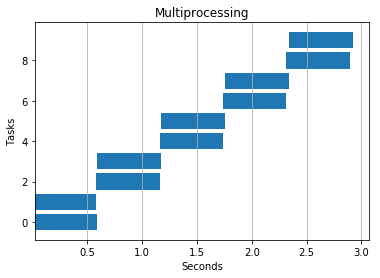

In [77]:
visualize_runtimes(multiprocessing(cpu_heavy, [N for i in range(ITERS)], 2),MULTIPROCESSING_TITLE)

3.706911563873291

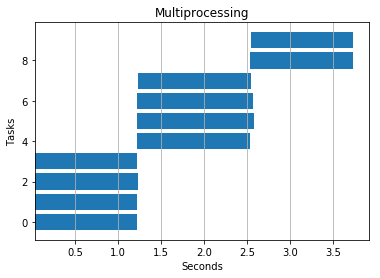

In [76]:
visualize_runtimes(multiprocessing(cpu_heavy, [N for i in range(ITERS)], 4),MULTIPROCESSING_TITLE)

# Resize Images

* https://github.com/python-pillow/Pillow/blob/c9f54c98a5dc18685a9bf8c8822f770492a796d6/_imagingtk.c

In [78]:
#This one takes IO so multithreading might be better?
def resize_img(fpath, base):
    img = Image.open(fpath)
    rimg = img.resize((224,224))
    img.close()
    return rimg

In [79]:
DATA_PATH='../data2/train/'
fnames = list(glob.iglob(DATA_PATH+'*/*.JPEG'))
N = 5000

#### Serial

In [80]:
%timeit -n 1 [resize_img(f, time.time()) for f in fnames[:N]]

26.7 s ± 77.2 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


#### Multithreading

In [81]:
%timeit -n 1 multithreading(resize_img, fnames[:N], 2)

14.7 s ± 2.21 s per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [82]:
%timeit -n 1 multithreading(resize_img, fnames[:N], 4)

10.9 s ± 18 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [83]:
%timeit -n 1 multithreading(resize_img, fnames[:N], 8)

11 s ± 19.2 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


#### Multiprocessing

In [84]:
%timeit -n 1 multiprocessing(resize_img, fnames[:N], 2)

16.2 s ± 750 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [85]:
%timeit -n 1 multiprocessing(resize_img, fnames[:N], 4)

12.4 s ± 18 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [86]:
%timeit -n 1 multiprocessing(resize_img, fnames[:N], 8)

13.1 s ± 39.7 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
